In [8]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)

from models import DeepConditionalModel
from inn_utils import train_online_ml, compute_metrics
from process_models import simulate_lotka_volterra
from viz import (plot_true_est_scatter, 
                plot_true_est_posterior, 
                plot_losses, 
                plot_sbc, 
                plot_metrics, plot_variance)

In [9]:
tf.enable_eager_execution()

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Summary network

In [11]:
class SequenceNetwork(tf.keras.Model):
    """
    Implements an LSTM summary network to summarize time-series data generated from the Ricker model.
    """
    
    def __init__(self, h_lstm_dim=32, h_dense_dim=64):
        super(SequenceNetwork, self).__init__()
        
        self.summary_part = tf.keras.Sequential([
            tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(h_lstm_dim)),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform', activation='elu'),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform')
        ])
    
    def call(self, x, **args):
        
        x = self.summary_part(x)
        return x

In [5]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}


# --- Training hyperparameters --- #
train = False
param_names = [r'$\alpha$', r'$\beta$', r'$\delta$', r'\gamma']
theta_dim = 4
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
summary_dim = 64
epochs = 50
iterations_per_epoch = 1000
n_inv_blocks = 3
n_test = 500
n_sbc = 5000
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 2000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)

In [6]:
X_test, theta_test = simulate_lotka_volterra(n_test, n_points=500)
# For SBC
X_sbc, theta_sbc = simulate_lotka_volterra(n_sbc, n_points=500)

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# Create networks

In [7]:
summary_net = SequenceNetwork(h_lstm_dim=summary_dim)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [15]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/lv', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


Instructions for updating:
Colocations handled automatically by placer.


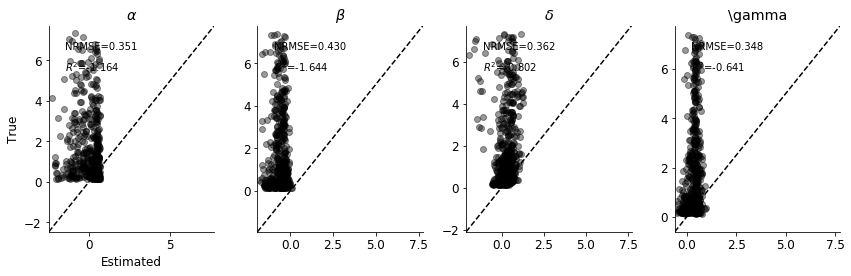

In [16]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(12, 4))

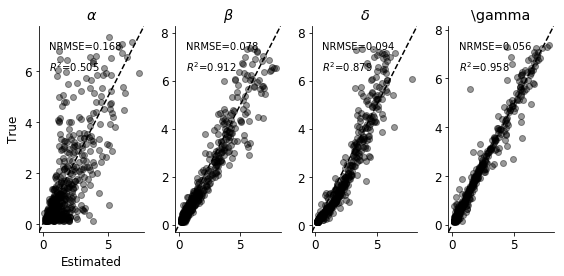

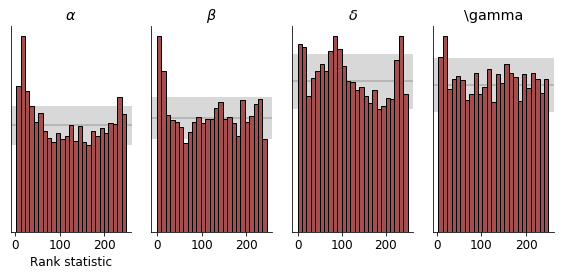

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [ ]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online_ml(model, optimizer, simulate_lotka_volterra, iterations_per_epoch, 
                            batch_size, p_bar, clip_value=clip_value, 
                            global_step=global_step)
        
        plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(8, 4))
        theta_samples = np.concatenate([model.sample(x, n_samples=250, to_numpy=True)
                                        for x in tf.split(X_sbc, 20, 0)], axis=0)
        plot_sbc(theta_samples, theta_sbc, param_names, figsize=(8, 4), bins=25)
        
        # Save model
        manager.save()